## Задание 5.1

Набор данных тут: https://github.com/sismetanin/rureviews, также есть в папке [Data](https://drive.google.com/drive/folders/1YAMe7MiTxA-RSSd8Ex2p-L0Dspe6Gs4L). Те, кто предпочитает работать с английским языком, могут использовать набор данных `sms_spam`.

Применим полученные навыки и решим задачу анализа тональности отзывов. 

Нужно повторить весь пайплайн от сырых текстов до получения обученной модели.

Обязательные шаги предобработки:
1. токенизация
2. приведение к нижнему регистру
3. удаление стоп-слов
4. лемматизация
5. векторизация (с настройкой гиперпараметров)
6. построение модели
7. оценка качества модели

Обязательно использование векторайзеров:
1. мешок n-грамм (диапазон для n подбирайте самостоятельно, запрещено использовать только униграммы).
2. tf-idf ((диапазон для n подбирайте самостоятельно, также нужно подбирать параметры max_df, min_df, max_features)
3. символьные n-граммы (диапазон для n подбирайте самостоятельно)

В качестве классификатора нужно использовать наивный байесовский классификатор. 

Для сравнения векторайзеров между собой используйте precision, recall, f1-score и accuracy. Для этого сформируйте датафрейм, в котором в строках будут разные векторайзеры, а в столбцах разные метрики качества, а в  ячейках будут значения этих метрик для соответсвующих векторайзеров.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/women-clothing-accessories.csv', sep='\t')

In [3]:
df.head()

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative
3,"товар не пришел, продавец продлил защиту без м...",negative
4,"Кофточка голая синтетика, носить не возможно.",negative


In [4]:
df['sentiment'] = df['sentiment'].map({'negative': 0,
                                       'neautral': 1,
                                       'positive': 2})

In [5]:
X = df['review'].to_list()
y = df['sentiment']

In [6]:
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
import pymorphy2
stopwords = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

In [7]:
%%time

punct_marks = string.punctuation + "—" + "«" + "»" + "`" + "``" + "..." + "“" \
+ "''" + "”" + '’' + '…'
auxiliary_pos = ['NPRO', 'PREP', 'CONJ', 'PRCL', 'INTJ']
for i in range(len(X)):
    X[i] = re.sub(r'@', '', X[i])  # удаление @
    X[i] = re.sub('http://\S+|https://\S+', '', X[i])  # удаление ссылок
    X[i] = re.sub('http[s]?://\S+', '', X[i])
    X[i] = word_tokenize(X[i])  # токенизация
    X[i] = [morph.parse(word)[0].normal_form for word in X[i]]  # лемматизация
    X[i] = [word.lower() for word in X[i] if word not in punct_marks]
    # нижний регистр и знаки препинания
    X[i] = [word for word in X[i] if morph.parse(word[0])[0].tag.POS not in auxiliary_pos]
    # удаление слов служебных частей речи

CPU times: user 28min 14s, sys: 2.39 s, total: 28min 16s
Wall time: 28min 18s


In [8]:
X = [' '.join(text) for text in X]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score

In [11]:
n_grams = [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 2), (2, 3), (2, 4), (2, 5),
          (2, 6), (3, 3), (3, 4)]
table_n_gram = {'vectorizer': [], 'param': [], 'precision': [], 'recall': [],
              'accuracy': [], 'f_1': []}

In [12]:
%%time

clf = MultinomialNB()
for param in n_grams:
    vectorizer = CountVectorizer(ngram_range=param)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    
    clf.fit(X_train_vectorized, y_train)
    y_pred = clf.predict(X_test_vectorized)
    
    table_n_gram['vectorizer'].append('n-grams')
    table_n_gram['param'].append(param)
    table_n_gram['precision'].append(precision_score(y_test, y_pred, average='macro'))
    table_n_gram['recall'].append(recall_score(y_test, y_pred, average='macro'))
    table_n_gram['accuracy'].append(accuracy_score(y_test, y_pred))
    table_n_gram['f_1'].append(f1_score(y_test, y_pred, average='macro'))
    
    print(param)

(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(3, 3)
(3, 4)
CPU times: user 2min 3s, sys: 2.15 s, total: 2min 5s
Wall time: 2min 5s


In [13]:
n_grams_table = pd.DataFrame.from_dict(table_n_gram)
n_grams_table

,vectorizer,param,precision,recall,accuracy,f_1
0,n-grams,"(1, 1)",0.657154,0.655376,0.655741,0.656190
1,n-grams,"(1, 2)",0.678057,0.675126,0.675481,0.676394
2,n-grams,"(1, 3)",0.677934,0.675758,0.676037,0.676554
3,n-grams,"(1, 4)",0.676975,0.674749,0.674963,0.675326
4,n-grams,"(1, 5)",0.677055,0.674622,0.674815,0.675195
5,n-grams,"(1, 6)",0.676925,0.674451,0.674630,0.674961
6,n-grams,"(1, 7)",0.676954,0.674497,0.674667,0.674955
7,n-grams,"(1, 8)",0.676965,0.674500,0.674667,0.674946
8,n-grams,"(2, 2)",0.649206,0.645015,0.645074,0.645352
9,n-grams,"(2, 3)",0.646515,0.643110,0.643111,0.642494


In [14]:
n_ranges = []
for i in range(6, 11):
    for j in range(2, 6):
        n_ranges.append((j, i))
table_n_char_gram = {'vectorizer': [], 'param': [], 'precision': [], 'recall': [], 
                     'accuracy': [], 'f_1': []}

In [15]:
table_n_char_gram = {'vectorizer': [], 'param': [], 'precision': [], 'recall': [], 
                     'accuracy': [], 'f_1': []}

In [16]:
table_n_char_gram

{'vectorizer': [],
 'param': [],
 'precision': [],
 'recall': [],
 'accuracy': [],
 'f_1': []}

In [17]:
%%time

for param in n_ranges:
    char_vectorizer = CountVectorizer(analyzer='char', ngram_range=param)
    X_train_vectorized = char_vectorizer.fit_transform(X_train)
    X_test_vectorized = char_vectorizer.transform(X_test)
    
    clf2 = MultinomialNB()
    clf2.fit(X_train_vectorized, y_train)
    y_pred = clf2.predict(X_test_vectorized)
    
    table_n_char_gram['vectorizer'].append('n-char-grams')
    table_n_char_gram['param'].append(param)
    table_n_char_gram['precision'].append(precision_score(y_test, y_pred, average='macro'))
    table_n_char_gram['recall'].append(recall_score(y_test, y_pred, average='macro'))
    table_n_char_gram['accuracy'].append(accuracy_score(y_test, y_pred))
    table_n_char_gram['f_1'].append(f1_score(y_test, y_pred, average='macro'))
    
    print(param)

(2, 6)
(3, 6)
(4, 6)
(5, 6)
(2, 7)
(3, 7)
(4, 7)
(5, 7)
(2, 8)
(3, 8)
(4, 8)
(5, 8)
(2, 9)
(3, 9)
(4, 9)
(5, 9)
(2, 10)
(3, 10)
(4, 10)
(5, 10)
CPU times: user 12min 32s, sys: 16.4 s, total: 12min 48s
Wall time: 12min 49s


In [18]:
n_char_grams_table = pd.DataFrame.from_dict(table_n_char_gram)
n_char_grams_table

,vectorizer,param,precision,recall,accuracy,f_1
0,n-char-grams,"(2, 6)",0.662442,0.656867,0.657296,0.658899
1,n-char-grams,"(3, 6)",0.663702,0.658772,0.659185,0.660638
2,n-char-grams,"(4, 6)",0.666155,0.661404,0.661815,0.663239
3,n-char-grams,"(5, 6)",0.667539,0.662827,0.663222,0.664700
4,n-char-grams,"(2, 7)",0.667646,0.662388,0.662815,0.664364
5,n-char-grams,"(3, 7)",0.670155,0.665032,0.665444,0.666985
6,n-char-grams,"(4, 7)",0.672012,0.667294,0.667704,0.669146
7,n-char-grams,"(5, 7)",0.671149,0.666639,0.667037,0.668466
8,n-char-grams,"(2, 8)",0.672851,0.667550,0.667963,0.669575
9,n-char-grams,"(3, 8)",0.673897,0.668928,0.669333,0.670866


In [44]:
ranges = [(1, i) for i in range(2, 5)]
max_dfs = [0.85, 0.95]
min_dfs = [i for i in range(1, 3)]
max_features = [50, 100, 200]

tf_idf_table = {'vectorizer': [], 'param': [], 'precision': [], 'recall': [],
              'accuracy': [], 'f_1': []}

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [46]:
%%time

for rang in ranges:
    for max_df in max_dfs:
        for min_df in min_dfs:
            for feat in max_features:
                tfidf_vectorizer = TfidfVectorizer(ngram_range=rang,
                                                   max_df=max_df, min_df=min_df, max_features=feat)
                X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)
                X_test_vectorized = tfidf_vectorizer.transform(X_test)
                clf3 = MultinomialNB()
                clf3.fit(X_train_vectorized, y_train)
                y_pred = clf3.predict(X_test_vectorized)
                print(tfidf_vectorizer)
            
                tf_idf_table['vectorizer'].append('tf-idf')
                tf_idf_table['param'].append(f"n:{rang}, min and max:({min_df},{max_df}), max_feats:{feat}")
                tf_idf_table['precision'].append(precision_score(y_test, y_pred, average='macro'))
                tf_idf_table['recall'].append(recall_score(y_test, y_pred, average='macro'))
                tf_idf_table['accuracy'].append(accuracy_score(y_test, y_pred))
                tf_idf_table['f_1'].append(f1_score(y_test, y_pred, average='macro'))

TfidfVectorizer(max_df=0.85, max_features=50, ngram_range=(1, 2))
TfidfVectorizer(max_df=0.85, max_features=100, ngram_range=(1, 2))
TfidfVectorizer(max_df=0.85, max_features=200, ngram_range=(1, 2))
TfidfVectorizer(max_df=0.85, max_features=50, min_df=2, ngram_range=(1, 2))
TfidfVectorizer(max_df=0.85, max_features=100, min_df=2, ngram_range=(1, 2))
TfidfVectorizer(max_df=0.85, max_features=200, min_df=2, ngram_range=(1, 2))
TfidfVectorizer(max_df=0.95, max_features=50, ngram_range=(1, 2))
TfidfVectorizer(max_df=0.95, max_features=100, ngram_range=(1, 2))
TfidfVectorizer(max_df=0.95, max_features=200, ngram_range=(1, 2))
TfidfVectorizer(max_df=0.95, max_features=50, min_df=2, ngram_range=(1, 2))
TfidfVectorizer(max_df=0.95, max_features=100, min_df=2, ngram_range=(1, 2))
TfidfVectorizer(max_df=0.95, max_features=200, min_df=2, ngram_range=(1, 2))
TfidfVectorizer(max_df=0.85, max_features=50, ngram_range=(1, 3))
TfidfVectorizer(max_df=0.85, max_features=100, ngram_range=(1, 3))
TfidfVe

In [47]:
tf_idf_table = pd.DataFrame.from_dict(tf_idf_table)
tf_idf_table

,vectorizer,param,precision,recall,accuracy,f_1
0,tf-idf,"n:(1, 2), min and max:(1,0.85), max_feats:50",0.564111,0.562996,0.563037,0.563159
1,tf-idf,"n:(1, 2), min and max:(1,0.85), max_feats:100",0.593623,0.593635,0.593889,0.593595
2,tf-idf,"n:(1, 2), min and max:(1,0.85), max_feats:200",0.625085,0.623677,0.624037,0.624305
3,tf-idf,"n:(1, 2), min and max:(2,0.85), max_feats:50",0.564111,0.562996,0.563037,0.563159
4,tf-idf,"n:(1, 2), min and max:(2,0.85), max_feats:100",0.593623,0.593635,0.593889,0.593595
5,tf-idf,"n:(1, 2), min and max:(2,0.85), max_feats:200",0.625085,0.623677,0.624037,0.624305
6,tf-idf,"n:(1, 2), min and max:(1,0.95), max_feats:50",0.564111,0.562996,0.563037,0.563159
7,tf-idf,"n:(1, 2), min and max:(1,0.95), max_feats:100",0.593623,0.593635,0.593889,0.593595
8,tf-idf,"n:(1, 2), min and max:(1,0.95), max_feats:200",0.625085,0.623677,0.624037,0.624305
9,tf-idf,"n:(1, 2), min and max:(2,0.95), max_feats:50",0.564111,0.562996,0.563037,0.563159


In [48]:
final = pd.concat([n_grams_table, n_char_grams_table, tf_idf_table], ignore_index=True)

In [50]:
pd.set_option('display.max_rows',75)

In [51]:
final

,vectorizer,param,precision,recall,accuracy,f_1
0,n-grams,"(1, 1)",0.657154,0.655376,0.655741,0.656190
1,n-grams,"(1, 2)",0.678057,0.675126,0.675481,0.676394
2,n-grams,"(1, 3)",0.677934,0.675758,0.676037,0.676554
3,n-grams,"(1, 4)",0.676975,0.674749,0.674963,0.675326
4,n-grams,"(1, 5)",0.677055,0.674622,0.674815,0.675195
5,n-grams,"(1, 6)",0.676925,0.674451,0.674630,0.674961
6,n-grams,"(1, 7)",0.676954,0.674497,0.674667,0.674955
7,n-grams,"(1, 8)",0.676965,0.674500,0.674667,0.674946
8,n-grams,"(2, 2)",0.649206,0.645015,0.645074,0.645352
9,n-grams,"(2, 3)",0.646515,0.643110,0.643111,0.642494


In [49]:
final

,vectorizer,param,precision,recall,accuracy,f_1
0,n-grams,"(1, 1)",0.657154,0.655376,0.655741,0.656190
1,n-grams,"(1, 2)",0.678057,0.675126,0.675481,0.676394
2,n-grams,"(1, 3)",0.677934,0.675758,0.676037,0.676554
3,n-grams,"(1, 4)",0.676975,0.674749,0.674963,0.675326
4,n-grams,"(1, 5)",0.677055,0.674622,0.674815,0.675195
...,...,...,...,...,...,...
66,tf-idf,"n:(1, 4), min and max:(1,0.95), max_feats:100",0.592787,0.592732,0.593000,0.592744
67,tf-idf,"n:(1, 4), min and max:(1,0.95), max_feats:200",0.623785,0.622435,0.622852,0.622964
68,tf-idf,"n:(1, 4), min and max:(2,0.95), max_feats:50",0.564111,0.562996,0.563037,0.563159
69,tf-idf,"n:(1, 4), min and max:(2,0.95), max_feats:100",0.592787,0.592732,0.593000,0.592744


In [54]:
final.sort_values(by='accuracy', ascending=False)[:5]

,vectorizer,param,precision,recall,accuracy,f_1
2,n-grams,"(1, 3)",0.677934,0.675758,0.676037,0.676554
1,n-grams,"(1, 2)",0.678057,0.675126,0.675481,0.676394
3,n-grams,"(1, 4)",0.676975,0.674749,0.674963,0.675326
4,n-grams,"(1, 5)",0.677055,0.674622,0.674815,0.675195
6,n-grams,"(1, 7)",0.676954,0.674497,0.674667,0.674955


In [93]:
final[final['vectorizer']=='n-grams']['accuracy'].max()

0.676037037037037

In [94]:
final[final['vectorizer']=='n-char-grams']['accuracy'].max()

0.6735925925925926

In [95]:
final[final['vectorizer']=='tf-idf']['accuracy'].max()

0.6240370370370371

Лучший результат дал мешок n-грамм с наименьшими значениями n_range

In [80]:
import seaborn as sns

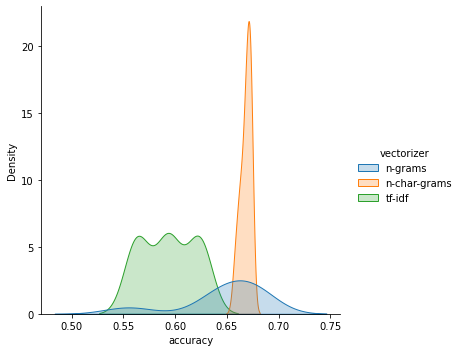

In [89]:
sns.displot(data=final, x='accuracy', hue='vectorizer', kind='kde', fill=True);

## Задание 5.2 Регулярные выражения

Регулярные выражения - способ поиска и анализа строк. Например, можно понять, какие даты в наборе строк представлены в формате DD/MM/YYYY, а какие - в других форматах. 

Или бывает, например, что перед работой с текстом, надо почистить его от своеобразного мусора: упоминаний пользователей, url и так далее.

Навык полезный, давайте в нём тоже потренируемся.

Для работы с регулярными выражениями есть библиотека **re**

In [55]:
import re

В регулярных выражениях, кроме привычных символов-букв, есть специальные символы:
* **?а** - ноль или один символ **а**
* **+а** - один или более символов **а**
* **\*а** - ноль или более символов **а** (не путать с +)
* **.** - любое количество любого символа

Пример:
Выражению \*a?b. соответствуют последовательности a, ab, abc, aa, aac НО НЕ abb!

Рассмотрим подробно несколько наиболее полезных функций:

### findall
возвращает список всех найденных непересекающихся совпадений.

Регулярное выражение **ab+c.**: 
* **a** - просто символ **a**
* **b+** - один или более символов **b**
* **c** - просто символ **c**
* **.** - любой символ


In [56]:
result = re.findall('ab+c.', 'abcdefghijkabcabcxabc') 
print(result)

['abcd', 'abca']


Вопрос на внимательность: почему нет abcx?

**Задание**: вернуть список первых двух букв каждого слова в строке, состоящей из нескольких слов.

In [57]:
result = re.findall(r'\b\w\w' ,"Национальные и культурные границы более прозрачны, чем раньше.")
result

['На', 'ку', 'гр', 'бо', 'пр', 'че', 'ра']

### split
разделяет строку по заданному шаблону


In [ ]:
result = re.split(',', 'itsy, bitsy, teenie, weenie') 
print(result)

['itsy', ' bitsy', ' teenie', ' weenie']


In [63]:
result = re.split(',', 'itsy, bitsy, teenie, weenie') 
print(result)

['itsy', ' bitsy', ' teenie', ' weenie']


можно указать максимальное количество разбиений

In [ ]:
result = re.split(',', 'itsy, bitsy, teenie, weenie', maxsplit=2) 
print(result)

['itsy', ' bitsy', ' teenie, weenie']


In [58]:
text = "Наш мир живет в ситуации глобализации. Национальные и культурные границы более прозрачны, чем раньше. Люди путешествуют по всему миру с разными целями: чтобы отдыхать, работать и учиться. Иногда чьи-то родственники или друзья живут за границей, и поездки туда становятся регулярными. Конечно, каждому нужен удобный и доступный способ путешествовать на дальние расстояния. Некоторые люди предпочитают традиционные поезда, но не все железные дороги проходят через государственные границы. Кроме того, путешествие на поезде обычно занимает много времени. Что касается путешествий по морю, они тоже могут быть невозможными (например, между странами Центральной Европы) или вызывать плохое самочувствие. Поэтому наиболее популярный способ ездить за границу – путешествие на самолете."

In [67]:
text

'Наш мир живет в ситуации глобализации. Национальные и культурные границы более прозрачны, чем раньше. Люди путешествуют по всему миру с разными целями: чтобы отдыхать, работать и учиться. Иногда чьи-то родственники или друзья живут за границей, и поездки туда становятся регулярными. Конечно, каждому нужен удобный и доступный способ путешествовать на дальние расстояния. Некоторые люди предпочитают традиционные поезда, но не все железные дороги проходят через государственные границы. Кроме того, путешествие на поезде обычно занимает много времени. Что касается путешествий по морю, они тоже могут быть невозможными (например, между странами Центральной Европы) или вызывать плохое самочувствие. Поэтому наиболее популярный способ ездить за границу – путешествие на самолете.'

**Задание**: разбейте строку, состоящую из нескольких предложений, по точкам, но не более чем на 3 предложения.

In [66]:
result = re.split(r'[.]', text, maxsplit=2)
result

['Наш мир живет в ситуации глобализации',
 ' Национальные и культурные границы более прозрачны, чем раньше',
 ' Люди путешествуют по всему миру с разными целями: чтобы отдыхать, работать и учиться. Иногда чьи-то родственники или друзья живут за границей, и поездки туда становятся регулярными. Конечно, каждому нужен удобный и доступный способ путешествовать на дальние расстояния. Некоторые люди предпочитают традиционные поезда, но не все железные дороги проходят через государственные границы. Кроме того, путешествие на поезде обычно занимает много времени. Что касается путешествий по морю, они тоже могут быть невозможными (например, между странами Центральной Европы) или вызывать плохое самочувствие. Поэтому наиболее популярный способ ездить за границу – путешествие на самолете.']

### sub
ищет шаблон в строке и заменяет все совпадения на указанную подстроку

параметры: (pattern, repl, string)

In [ ]:
result = re.sub('a', 'b', 'abcabc')
print (result)

bbcbbc


In [68]:
text = "Наибольшее количество побед в сезоне (38 матчей): 29, «Челси» (2004/05, 2005/06)"

**Задание**: напишите регулярное выражение, которое позволит заменить все цифры в строке на "DIG".

In [72]:
result = re.sub(r'\d', "DIG", text)  # если надо заменить все цифры
result

'Наибольшее количество побед в сезоне (DIGDIG матчей): DIGDIG, «Челси» (DIGDIGDIGDIG/DIGDIG, DIGDIGDIGDIG/DIGDIG)'

In [73]:
result = re.sub(r'\d+', "DIG", text)  # если надо заменить все числа
result

'Наибольшее количество побед в сезоне (DIG матчей): DIG, «Челси» (DIG/DIG, DIG/DIG)'

**Задание**: напишите  регулярное выражение, которое позволит убрать url из строки.

In [74]:
text = 'Документация библиотеки re доступна по ссылке https://docs.python.org/3/library/re.html'

In [76]:
result = re.sub(r'http\S+', '', text)
result

'Документация библиотеки re доступна по ссылке '

### compile
компилирует регулярное выражение в отдельный объект

In [ ]:
# Пример: построение списка всех слов строки:
prog = re.compile('[А-Яа-яё\-]+')
prog.findall("Слова? Да, больше, ещё больше слов! Что-то ещё.")

['Слова', 'Да', 'больше', 'ещё', 'больше', 'слов', 'Что-то', 'ещё']

**Задание**: для выбранной строки постройте список слов, которые длиннее трех символов.

In [78]:
result = re.compile(r'\S{3,}\b')
result.findall("Национальные и культурные границы более прозрачны, чем раньше.")

['Национальные',
 'культурные',
 'границы',
 'более',
 'прозрачны',
 'чем',
 'раньше']

**Задание**: вернуть список доменов (@gmail.com) из списка адресов электронной почты:

```
abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz
```

In [79]:
result = re.compile("@[\w.]+")
result.findall("abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz")

['@gmail.com', '@test.in', '@analyticsvidhya.com', '@rest.biz']